In [1]:
execute_cell_10 = False
execute_cell_8 = True

In [2]:
import pandas as pd

# Load the merged dataset
file_path = "../data/processed/merged_data.csv"  # Adjust if needed
df = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date")

# Display basic info
print(df.info())
display(df.head())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2020-01-02 to 2024-12-31
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               1258 non-null   float64
 1   High               1258 non-null   float64
 2   Low                1258 non-null   float64
 3   Close              1258 non-null   float64
 4   Volume             1258 non-null   int64  
 5   Dividends          1258 non-null   float64
 6   Stock Splits       1258 non-null   float64
 7   Interest Rate      42 non-null     float64
 8   Inflation Rate     42 non-null     float64
 9   GDP Growth         13 non-null     float64
 10  Unemployment Rate  42 non-null     float64
dtypes: float64(10), int64(1)
memory usage: 117.9 KB
None


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Interest Rate,Inflation Rate,GDP Growth,Unemployment Rate
Date,,,,,,,,,,,
2020-01-02,71.721011,72.776591,71.466805,72.716064,135480400,0.0,0.0,NaN,NaN,NaN,NaN
2020-01-03,71.941343,72.771760,71.783977,72.009132,146322800,0.0,0.0,NaN,NaN,NaN,NaN
2020-01-06,71.127866,72.621646,70.876075,72.582909,118387200,0.0,0.0,NaN,NaN,NaN,NaN
2020-01-07,72.592601,72.849231,72.021238,72.241554,108872000,0.0,0.0,NaN,NaN,NaN,NaN
2020-01-08,71.943759,73.706279,71.943759,73.403648,132079200,0.0,0.0,NaN,NaN,NaN,NaN


In [3]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])


Interest Rate        1216
Inflation Rate       1216
GDP Growth           1245
Unemployment Rate    1216
dtype: int64


In [4]:
# Fill missing values using forward fill (propagating previous values)
df = df.ffill()

# Alternatively, use backward fill
# df.fillna(method='bfill', inplace=True)

# Verify missing values are handled
print(df.isnull().sum().sum())  # Should be 0


80


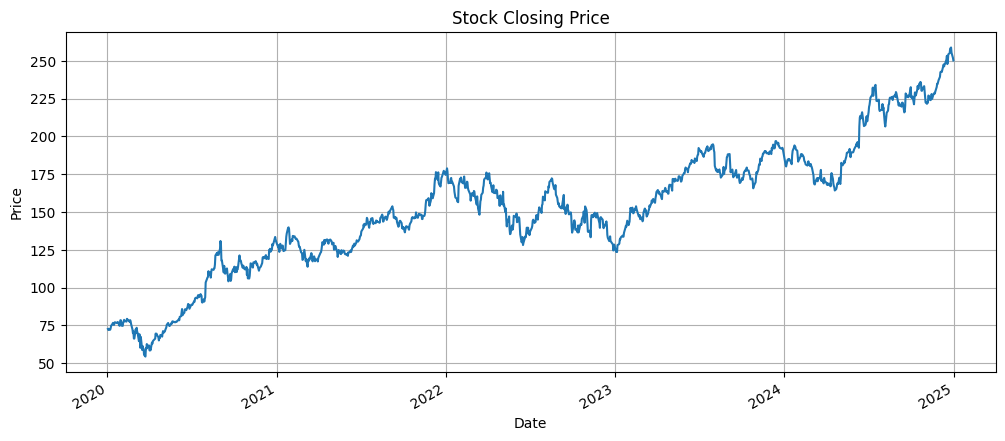

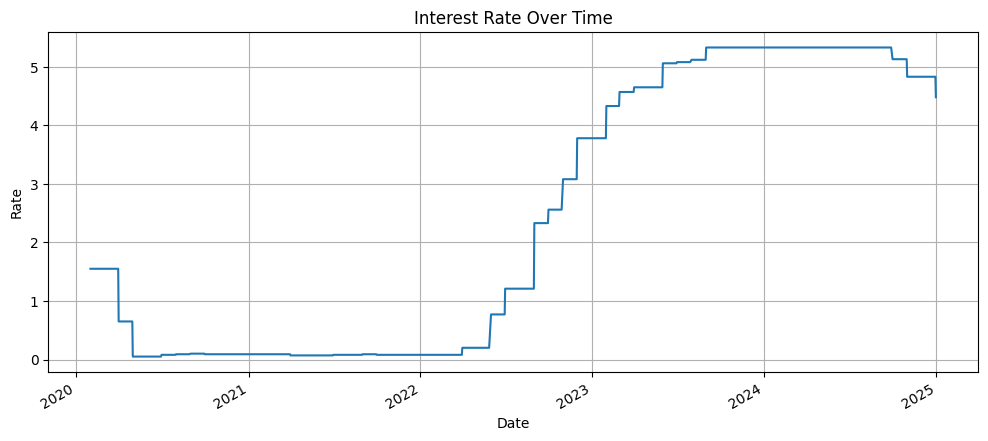

In [5]:
import matplotlib.pyplot as plt

# Plot closing stock price
df['Close'].plot(figsize=(12, 5), title="Stock Closing Price", ylabel="Price", grid=True)
plt.show()

# Plot an economic indicator (e.g., Interest Rate)
df['Interest Rate'].plot(figsize=(12, 5), title="Interest Rate Over Time", ylabel="Rate", grid=True)
plt.show()


In [6]:
# Compute correlation matrix
correlation_matrix = df.corr()

# Display correlation with the stock's closing price
print(correlation_matrix["Close"].sort_values(ascending=False))


Close                1.000000
High                 0.999398
Low                  0.999395
Open                 0.998661
GDP Growth           0.874802
Inflation Rate       0.860061
Interest Rate        0.694199
Dividends            0.009217
Stock Splits        -0.017672
Unemployment Rate   -0.546314
Volume              -0.638028
Name: Close, dtype: float64


In [7]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import numpy as np

# Select only the important features based on the feature importance plot
features = ["Open", "High", "Low", "GDP Growth"]  # Dropped less important ones
target = "Close"

# Create feature & target datasets
X = df[features]
y = df[target]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle missing values
X_train = X_train.ffill().bfill()
X_test = X_test.ffill().bfill()

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the XGBoost model
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Define a refined parameter grid for hyperparameter tuning
param_dist = {
    'n_estimators': [100, 300, 500, 700],
    'learning_rate': [0.01, 0.03, 0.05, 0.2],
    'max_depth': [ 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.75, 0.9],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_lambda': [0.1, 0.1, 1, 10],  # L2 regularization
    'reg_alpha': [0.1, 0.1, 1, 10]   # L1 regularization
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    scoring='neg_mean_absolute_error',
    n_iter=50,  # Run 20 different random combinations
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Train and optimize model
random_search.fit(X_train_scaled, y_train)

# Retrieve the best model
best_xgb = random_search.best_estimator_

# Make predictions using the best model
y_pred = best_xgb.predict(X_test_scaled)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print performance results
print(f"Optimized XGBoost - MAE: {mae}")
print(f"Optimized XGBoost - MSE: {mse}")
print(f"Optimized XGBoost - RMSE: {rmse}")
print(f"Optimized XGBoost - R²: {r2}")

# Print best hyperparameters
print(f"Best Parameters: {random_search.best_params_}")



Fitting 5 folds for each of 50 candidates, totalling 250 fits
Optimized XGBoost - MAE: 1.0454001956515846
Optimized XGBoost - MSE: 2.4192426888863934
Optimized XGBoost - RMSE: 1.5553914905535497
Optimized XGBoost - R²: 0.9986167995732044
Best Parameters: {'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.05, 'colsample_bytree': 1.0}


In [8]:
if execute_cell_8:
  print(X_train.isnull().sum().sum())  # Should print 0
  print("This cell was executed.")
else:
    print("This cell was skipped.")




0
This cell was executed.


In [9]:
 import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Check on train and test sets
y_train_pred = best_xgb.predict(X_train_scaled)
y_test_pred = best_xgb.predict(X_test_scaled)

print("Train R²:", r2_score(y_train, y_train_pred))
print("Test R²:", r2_score(y_test, y_test_pred))

print("Train MAE:", mean_absolute_error(y_train, y_train_pred))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred))  


Train R²: 0.9997966762226359
Test R²: 0.9986167995732044
Train MAE: 0.43491540609249735
Test MAE: 1.0454001956515846


In [10]:
import joblib
from sklearn.preprocessing import StandardScaler  # or StandardScaler
if execute_cell_10:
# Assuming you used a scaler during training
 scaler = StandardScaler()
 scaler.fit(X_train)  # Fit on training data
else:
 print("not fit again") 
# Save both model and scaler
joblib.dump(best_xgb, "xgboost_model.pkl", compress=3)
joblib.dump(scaler, "scaler.pkl")

print("Model and Scaler saved successfully!")
  

not fit again
Model and Scaler saved successfully!


In [11]:
import os
print(os.path.exists("xgboost_model.pkl"))  # Should return True if the file exists


True


In [21]:
import joblib
import numpy as np

# Load the saved model and scaler
model = joblib.load("xgboost_model.pkl")
scaler = joblib.load("scaler.pkl")

# Check predictions on training data
X_train_scaled = scaler.transform(X_train)  # Ensure this matches training process
y_train_pred = model.predict(X_train_scaled)

print("Sample Training Predictions:", y_train_pred[:10])


Sample Training Predictions: [228.64458 117.95024 208.05028 215.6171  140.12102 130.75159 160.5816
 227.9621  143.47275 170.97594]


In [20]:
import joblib
import numpy as np
import xgboost as xgb
from flask import Flask, request, jsonify
import os

# Get absolute paths
model_path = os.path.abspath("xgboost_model.pkl")
scaler_path = os.path.abspath("scaler.pkl")  # Load the same scaler used in training

print(f"Loading model from: {model_path}")
print(f"Loading scaler from: {scaler_path}")

# Load model and scaler
model = joblib.load(model_path, mmap_mode="r")
scaler = joblib.load(scaler_path)  # Load the MinMaxScaler or StandardScaler




# Initialize Flask app
app = Flask(__name__)

@app.route("/")
def home():
    return "Flask API for Stock Prediction is Running!"

@app.route("/predict", methods=["POST", "GET"])
def predict():
    try:
        if request.method == "GET":
            return jsonify({"message": "Use POST with JSON data to get predictions"}), 200

        # Get JSON data from request
        data = request.get_json()

        # Ensure data is in correct format (list of feature values)
        features = np.array(data["features"]).reshape(1, -1)

        #ensure the features list has the correct number of inputs:
        if len(features[0]) != X_train.shape[1]:
          return jsonify({"error": "Feature size mismatch"}), 400
        
        # Scale the input features before prediction
        features_scaled = scaler.transform(features)

        # Make prediction
        prediction = model.predict(features_scaled)

        # Return prediction as JSON response
        return jsonify({"prediction": prediction.tolist()})
    
    except Exception as e:
        return jsonify({"error": str(e)})

# Run the app
if __name__ == "__main__":
    app.run(host="0.0.0.0", port=5000, debug=True)


Loading model from: C:\Users\saifz\Documents\computersoftware\Python\stock_prediction_project\src\xgboost_model.pkl
Loading scaler from: C:\Users\saifz\Documents\computersoftware\Python\stock_prediction_project\src\scaler.pkl
 * Serving Flask app '__main__'
 * Debug mode: on


C:\Users\saifz\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:137: UserWarning: mmap_mode "r" is not compatible with compressed file C:\Users\saifz\Documents\computersoftware\Python\stock_prediction_project\src\xgboost_model.pkl. "r" flag will be ignored.
  return next(self.gen)
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.0.116:5000
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1

C:\Users\saifz\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
print("X_train_scaled shape:", X_train_scaled.shape)
print("y_train shape:", y_train.shape)


In [ ]:
print("Feature Importances:", best_xgb.feature_importances_)


In [ ]:
print("Sample Scaled Features:", X_train_scaled[:5])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Feature names (update with actual names if available)
feature_names = ["Feature 1", "Feature 2", "Feature 3", "Feature 4"]
feature_importances = np.array([1.0780316e-01, 4.7769189e-01, 4.1415021e-01, 3.5477889e-04])

# Plot feature importance
plt.figure(figsize=(8, 5))
plt.barh(feature_names, feature_importances, color="skyblue")
plt.xlabel("Importance Score")
plt.title("Feature Importance Visualization")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


In [ ]:
%tb


In [14]:
import requests

url = "http://127.0.0.1:5000/predict"
data = {"features": [1.2, 3.4, 5.6, 7.8, 2.3, 4.5, 6.7]}  # Update with actual feature values
response = requests.post(url, json=data)

print("Response:", response.json())

Response: {'prediction': [57.90605926513672]}


In [ ]:
data = {"features": [2.1, 4.3, 6.5, 8.7, 3.2, 5.4, 7.6]}  
response = requests.post(url, json=data)  
print("Response:", response.json())


In [ ]:
data = {"features": [500, 500, 300, 1400, 500, 1600, 2700]}
response = requests.post(url, json=data)  
print("Response:", response.json())


In [ ]:
data = {"features": [10, 20, 30, 40, 50, 60, 70]}
response = requests.post(url, json=data)  
print("Response:", response.json())

In [ ]:
data = {"features": [-5, 0, 5, 10, 15, 20, 25]}
response = requests.post(url, json=data)  
print("Response:", response.json())

In [ ]:
data = {"features": [100, 200, 15, 210, 1115, 120, 225]}
response = requests.post(url, json=data)  
print("Response:", response.json())

In [ ]:
data = {"features": [-6, 1, 4, 11, 14, 21, 26]}
response = requests.post(url, json=data)  
print("Response:", response.json())

In [ ]:
import pandas as pd

# Assuming `X_train` was used to train the model
print("Training Data Sample:")
print(pd.DataFrame(X_train).head())  # Print first few rows

print("\nFeature Min Values:", X_train.min(axis=0))
print("Feature Max Values:", X_train.max(axis=0))


In [ ]:
import os
print(os.path.exists("xgboost_model.pkl"))

In [ ]:
import os

print("Model exists:", os.path.exists("xgboost_model.pkl"))
print("Scaler exists:", os.path.exists("scaler.pkl"))


In [ ]:
import joblib

try:
    model = joblib.load("xgboost_model.pkl")
    print("Model loaded successfully!")
except Exception as e:
    print("Error loading model:", e)

try:
    scaler = joblib.load("scaler.pkl")
    print("Scaler loaded successfully!")
except Exception as e:
    print("Error loading scaler:", e)


In [ ]:
@app.route("/predict", methods=["POST"])
def predict():
    try:
        data = request.get_json()
        print("Received JSON:", data)  # Debugging line
        
        features = np.array(data["features"]).reshape(1, -1)
        features_scaled = scaler.transform(features)
        prediction = model.predict(features_scaled)

        return jsonify({"prediction": prediction.tolist()})
    
    except Exception as e:
        return jsonify({"error": str(e)})


In [ ]:
print(app.url_map)


In [ ]:
import joblib
import numpy as np

# Load the saved model and scaler
model = joblib.load("xgboost_model.pkl")
scaler = joblib.load("scaler.pkl")

# Check predictions on training data
X_train_scaled = scaler.transform(X_train)  # Ensure this matches training process
y_train_pred = model.predict(X_train_scaled)

print("Sample Training Predictions:", y_train_pred[:10])


In [ ]:
X_test_scaled = scaler.transform(X_test)
print("Scaled Features Range:")
print("Min:", np.min(X_test_scaled, axis=0))
print("Max:", np.max(X_test_scaled, axis=0))


In [ ]:
import matplotlib.pyplot as plt

xgb.plot_importance(model)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(best_xgb)
plt.show()


In [ ]:
print(f"y_train Min: {y_train.min()}, y_train Max: {y_train.max()}")
print(f"y_test Min: {y_test.min()}, y_test Max: {y_test.max()}")


In [ ]:
print("Feature Variance After Scaling:", np.var(X_train_scaled, axis=0))


In [ ]:
print(pd.DataFrame(X_train_scaled).head())


In [ ]:
y_train_pred = best_xgb.predict(X_train_scaled)
print("Sample Training Predictions:", y_train_pred[:10])


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importance
feature_importance = best_xgb.feature_importances_

# Plot feature importance
plt.figure(figsize=(8, 5))
plt.bar(range(len(feature_importance)), feature_importance)
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.title("Feature Importance")
plt.show()


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
print(f"Linear Regression MAE: {mae_lr}")


In [ ]:
import shap
import matplotlib.pyplot as plt

# Create SHAP explainer
explainer = shap.Explainer(best_xgb, X_train_scaled)
shap_values = explainer(X_train_scaled)

# SHAP summary plot
shap.summary_plot(shap_values, X_train_scaled, feature_names=["Open", "High", "Low", "Inflation Rate"])


In [15]:
import numpy as np
print("y_train mean:", np.mean(y_train))
print("y_train std deviation:", np.std(y_train))
print("Unique y_train values:", np.unique(y_train))

y_train mean: 152.76851625613142
y_train std deviation: 42.09440871264333
Unique y_train values: [ 54.44989395  58.46380615  58.58513641  58.77928543  59.40296936
  59.58255005  59.86164093  60.12129974  60.24020767  61.71084595
  61.83704758  62.95821762  64.56961823  64.59388733  65.03554535
  65.12776184  66.3120575   66.33872986  66.37756348  66.74401093
  66.84107971  67.20509338  67.60552216  68.62962341  68.71941376
  69.02519989  69.24604034  69.57365417  69.91096497  70.15123749
  70.2118988   71.0200119   71.1437912   71.29910278  72.00913239
  72.21155548  72.24155426  72.36204529  72.5149231   72.58290863
  72.71606445  73.40364838  73.46864319  73.71133423  74.72794342
  74.79816437  74.86229706  74.87691498  74.93374634  74.9628067
  75.13227844  75.32221222  75.37680054  75.46579742  75.70121765
  75.7772522   75.97064972  76.19821167  76.64109039  76.643013
  76.65326691  76.73742676  76.91414642  76.91658783  77.06426239
  77.07178497  77.10100555  77.16595459  77.1949

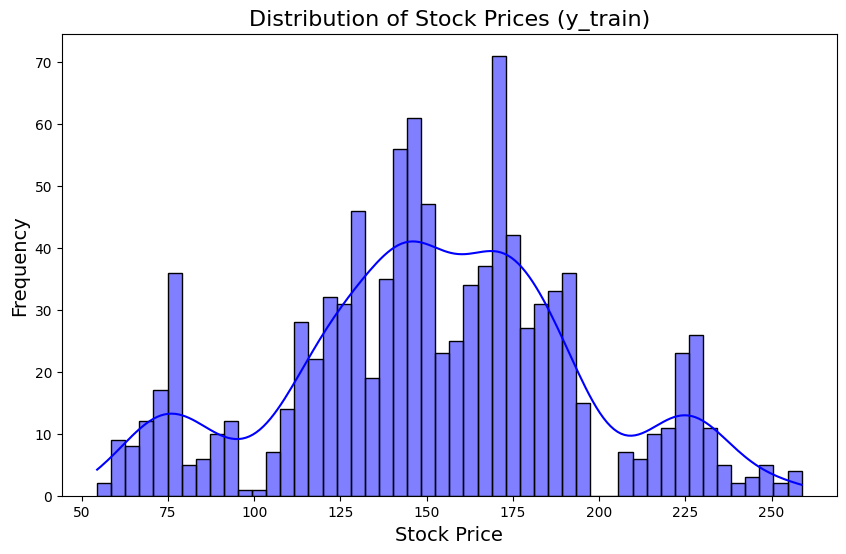

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histogram with KDE
plt.figure(figsize=(10, 6))
sns.histplot(y_train, bins=50, kde=True, color='blue')

# Labels and title
plt.xlabel("Stock Price", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Distribution of Stock Prices (y_train)", fontsize=16)

# Show plot
plt.show()


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

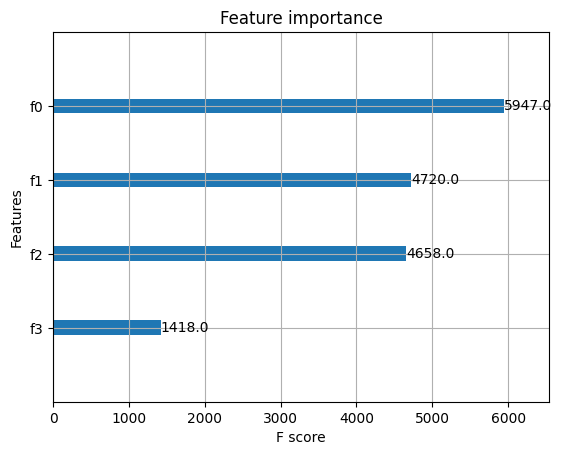

In [17]:
from xgboost import plot_importance
plot_importance(model)


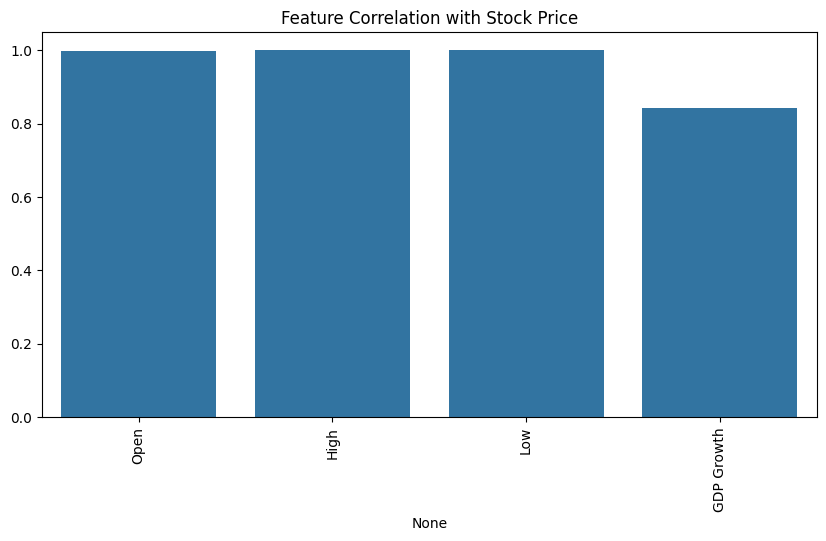

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = X_train.corrwith(y_train)
plt.figure(figsize=(10,5))
sns.barplot(x=corr.index, y=corr.values)
plt.xticks(rotation=90)
plt.title("Feature Correlation with Stock Price")
plt.show()

